# Generalized 1D heat transfer solver



## 1D Transient Heat Equation Discretization

We consider the governing equation

$$
\rho(x,t,T)\, c_p(x,t,T)\, \frac{\partial T}{\partial t}
= \frac{\partial}{\partial x} \Big( k(x,t,T)\, \frac{\partial T}{\partial x} \Big) + \dot q(x,t)
$$

on a 1D domain $x \in [0,L]$.

---

### Grid

- Uniform grid with $N$ nodes:
  $$
  x_i = i \,\Delta x, \qquad \Delta x = \frac{L}{N-1}, \qquad i=0,1,\dots,N-1
  $$

- Unknowns: $T_i^n \equiv T(x_i,t^n)$.

---

### Time Discretization

We use the **$\theta$-method**:

$$
\rho_i c_{p,i}\, \frac{T_i^{n+1} - T_i^n}{\Delta t} =
\theta \,\mathcal{L}[T^{n+1}]_i + (1-\theta)\,\mathcal{L}[T^n]_i
+ \theta \,\dot q_i^{n+1} + (1-\theta)\,\dot q_i^n
$$

- $\theta = 0.5$: Crank–Nicolson  
- $\theta = 1$: fully implicit Euler  

Here $\mathcal{L}[T]_i$ is the diffusion operator at node $i$.

---

### Spatial Discretization

At interface $i+\tfrac{1}{2}$, the flux is

$$
q_{i+1/2} = -k_{i+1/2}\, \frac{T_{i+1} - T_i}{\Delta x}
$$

with harmonic mean conductivity:

$$
k_{i+1/2} = \frac{2 k_i k_{i+1}}{k_i + k_{i+1}}.
$$

The divergence term at node $i$ is

$$
\mathcal{L}[T]_i = \frac{ k_{i+1/2}(T_{i+1}-T_i) - k_{i-1/2}(T_i-T_{i-1}) }{(\Delta x)^2}.
$$

---

### Interior Node Equation

For $i=1,\dots,N-2$:

$$
\begin{aligned}
\rho_i c_{p,i}\, \frac{T_i^{n+1}-T_i^n}{\Delta t} &=
\theta \left[ \frac{k_{i+1/2}^{n+1}(T_{i+1}^{n+1}-T_i^{n+1})}{(\Delta x)^2}
- \frac{k_{i-1/2}^{n+1}(T_i^{n+1}-T_{i-1}^{n+1})}{(\Delta x)^2} \right] \\[6pt]
&\quad + (1-\theta)\left[ \frac{k_{i+1/2}^{n}(T_{i+1}^{n}-T_i^{n})}{(\Delta x)^2}
- \frac{k_{i-1/2}^{n}(T_i^{n}-T_{i-1}^{n})}{(\Delta x)^2} \right] \\[6pt]
&\quad + \theta \,\dot q_i^{n+1} + (1-\theta)\,\dot q_i^n.
\end{aligned}
$$

This rearranges into a tridiagonal system:

$$
-a_i T_{i-1}^{n+1} + b_i T_i^{n+1} - c_i T_{i+1}^{n+1} = d_i
$$

with

$$
a_i = - \frac{\theta \Delta t}{\rho_i^{n+1} c_{p,i}^{n+1}} \frac{k_{i-1/2}^{n+1}}{(\Delta x)^2},
$$

$$
c_i = - \frac{\theta \Delta t}{\rho_i^{n+1} c_{p,i}^{n+1}} \frac{k_{i+1/2}^{n+1}}{(\Delta x)^2},
$$

$$
b_i = 1 - (a_i+c_i),
$$

$$
d_i = T_i^n
+ \frac{\Delta t}{\rho_i^n c_{p,i}^n} \Big[ (1-\theta)\,\mathcal{L}[T^n]_i + (1-\theta)\,\dot q_i^n \Big]
+ \frac{\Delta t}{\rho_i^{n+1} c_{p,i}^{n+1}} \,\theta \dot q_i^{n+1}.
$$

## Boundary Condition Implementation in the Discretized System

For interior nodes $i=1,\dots,N-2$, the discretization leads to the standard
tridiagonal form

$$
-a_i T_{i-1}^{n+1} + b_i T_i^{n+1} - c_i T_{i+1}^{n+1} = d_i.
$$

At the boundary nodes ($i=0$ and $i=N-1$), the system is modified
depending on the boundary condition type.

---

### 1. Dirichlet boundary condition

At the left boundary $x=0$,

$$
T_0^{n+1} = T_{\text{spec}}(t^{n+1}).
$$

Implementation: replace the first row of the matrix with

$$
a_0 = 0, \quad b_0 = 1, \quad c_0 = 0, \quad d_0 = T_{\text{spec}}(t^{n+1}).
$$

Analogously at $i=N-1$.

---

### 2. Neumann boundary condition

Specified flux $q''(t)$, positive into the domain:

$$
-k \frac{\partial T}{\partial x}\bigg|_{0} = q''(t).
$$

Discretized using a one-sided difference:

$$
\frac{T_1^{n+1} - T_0^{n+1}}{\Delta x}
= -\frac{q''(t^{n+1})}{k_{1/2}}.
$$

The left boundary equation becomes

$$
b_0 T_0^{n+1} - c_0 T_1^{n+1} = d_0,
$$

with

$$
b_0 = 1 + \theta \frac{\Delta t}{\rho_0 c_{p,0}}
\frac{k_{1/2}}{(\Delta x)^2},
$$

$$
c_0 = \theta \frac{\Delta t}{\rho_0 c_{p,0}}
\frac{k_{1/2}}{(\Delta x)^2},
$$

$$
d_0 = T_0^n + \ldots +
\theta \frac{\Delta t}{\rho_0 c_{p,0}}
\frac{2 q''(t^{n+1})}{\Delta x}.
$$

(The dots `$\ldots$` denote explicit diffusion and source terms as in the
interior equation.)

At the right boundary ($i=N-1$), the flux condition is treated analogously.

---

### 3. Robin (convection) boundary condition

At the left boundary $x=0$,

$$
- k \frac{\partial T}{\partial x}\bigg|_{0}
= h \,\big(T_0^{n+1} - T_\infty^{n+1}\big).
$$

Discretization gives

$$
\frac{T_1^{n+1}-T_0^{n+1}}{\Delta x}
= -\frac{h}{k_{1/2}}\big(T_0^{n+1}-T_\infty^{n+1}\big).
$$

This leads to a modified boundary equation

$$
b_0 T_0^{n+1} - c_0 T_1^{n+1} = d_0,
$$

with

$$
b_0 = 1 + \theta \frac{\Delta t}{\rho_0 c_{p,0}}
\left( \frac{k_{1/2}}{(\Delta x)^2} + \frac{2h}{\Delta x} \right),
$$

$$
c_0 = \theta \frac{\Delta t}{\rho_0 c_{p,0}}
\frac{k_{1/2}}{(\Delta x)^2},
$$

$$
d_0 = T_0^n + \ldots +
\theta \frac{\Delta t}{\rho_0 c_{p,0}}
\frac{2h}{\Delta x}\, T_\infty^{n+1}.
$$

At the right boundary ($i=N-1$ ), the convection condition is applied analogously.

---

### Summary

- **Dirichlet:** enforce $T = T_{\text{spec}}$ by setting row to identity.  
- **Neumann:** modifies diagonal and RHS with imposed flux $q''$.  
- **Robin:** adds diagonal contribution from $h$ and RHS contribution from $h T_\infty$.  


In [7]:
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import Callable, Tuple, Literal

BCType = Literal["Dirichlet", "Neumann", "Robin"]  # Robin = convection: (-k dT/dx) = h (T_surface - T_inf)

@dataclass
class MaterialFuncs:
    rho: Callable[[np.ndarray, float, np.ndarray], np.ndarray]  # rho(x, t, T)
    cp: Callable[[np.ndarray, float, np.ndarray], np.ndarray]   # cp(x, t, T)
    k:  Callable[[np.ndarray, float, np.ndarray], np.ndarray]   # k(x, t, T)

@dataclass
class SourceFunc:
    qdot: Callable[[np.ndarray, float], np.ndarray]  # qdot(x, t) [W/m^3]

@dataclass
class BCFunc:
    # For "Robin", return value as a 2-tuple: (h, T_inf)
    left:  Callable[[float], Tuple[BCType, object]]
    right: Callable[[float], Tuple[BCType, object]]

@dataclass
class Grid1D:
    L: float
    N: int

    def __post_init__(self):
        assert self.N >= 2, "Need at least 2 grid points"
        self.x = np.linspace(0.0, self.L, self.N)
        self.dx = self.x[1] - self.x[0]

def harmonic_mean(a, b, eps=1e-20):
    """Harmonic mean guard against zeros."""
    return 2.0 * a * b / np.maximum(a + b, eps)

def thomas_solve(a, b, c, d):
    """
    Solve tridiagonal system with subdiag a[1:], diag b, superdiag c[:-1], RHS d.
    All arrays length N. In-place safe for copies created here.
    """
    n = len(b)
    ac, bc, cc, dc = map(np.array, (a.copy(), b.copy(), c.copy(), d.copy()))
    # Forward elimination
    for i in range(1, n):
        m = ac[i] / bc[i-1]
        bc[i] -= m * cc[i-1]
        dc[i] -= m * dc[i-1]
    # Back substitution
    x = np.zeros_like(dc)
    x[-1] = dc[-1] / bc[-1]
    for i in range(n-2, -1, -1):
        x[i] = (dc[i] - cc[i] * x[i+1]) / bc[i]
    return x

class Heat1DSolver:
    """
    Generalized 1D heat equation solver with variable properties and time-dependent BCs.

    Governing equation:
        rho(x,t,T) * cp(x,t,T) * dT/dt = d/dx[ k(x,t,T) * dT/dx ] + qdot(x,t)

    Discretization:
        - Uniform grid, finite-volume / finite-difference hybrid
        - Crank–Nicolson (theta-method) in time with optional Picard iterations for nonlinearity
        - Dirichlet BC: T at boundary node set directly
        - Neumann BC: specified heat flux q''(t) [W/m^2], positive INTO domain
        - Robin BC: convection: -k dT/dx = h (T_surface - T_inf(t))
    """
    def __init__(
        self,
        grid: Grid1D,
        material: MaterialFuncs,
        source: SourceFunc,
        bc: BCFunc,
        theta: float = 0.5,         # 0.5 = Crank–Nicolson, 1 = implicit Euler
        max_iter: int = 10,
        tol: float = 1e-8,
    ):
        assert 0.0 < theta <= 1.0, "theta in (0,1]"
        self.g = grid
        self.mat = material
        self.src = source
        self.bc = bc
        self.theta = theta
        self.max_iter = max_iter
        self.tol = tol

    def _assemble_system(self, Tn: np.ndarray, dt: float, t_n: float, t_np1: float):
        """
        Assemble tridiagonal system a,b,c,d for solve at time t^{n+1}.
        We use Picard linearization: properties evaluated at (x, t*, T*), where t* = t^{n+1} for implicit part,
        and at (x, t^n, T^n) for explicit part.
        """
        x, dx = self.g.x, self.g.dx
        N = self.g.N
        theta = self.theta

        # Properties at old time (explicit) and predictors at new time (implicit)
        rho_n = self.mat.rho(x, t_n, Tn)
        cp_n  = self.mat.cp(x, t_n, Tn)
        k_n   = self.mat.k(x, t_n, Tn)

        # Begin with a predictor for T^{n+1} to evaluate props; use Tn initially
        Tstar = Tn.copy()

        # Initialize tridiagonal arrays
        a = np.zeros(N)  # sub-diagonal
        b = np.zeros(N)  # diagonal
        c = np.zeros(N)  # super-diagonal
        d = np.zeros(N)  # RHS

        # Precompute explicit operator L(Tn) and qdot parts
        k_e_n = harmonic_mean(k_n[:-1], k_n[1:])  # faces i+1/2, length N-1
        L_Tn = np.zeros(N)
        L_Tn[1:-1] = (k_e_n[1:] * (Tn[2:] - Tn[1:-1]) - k_e_n[:-1] * (Tn[1:-1] - Tn[:-2])) / (dx*dx)
        q_n = self.src.qdot(x, t_n)

        # Picard iterations
        for _it in range(self.max_iter):
            rho_np1 = self.mat.rho(x, t_np1, Tstar)
            cp_np1  = self.mat.cp(x, t_np1, Tstar)
            k_np1   = self.mat.k(x, t_np1, Tstar)

            Cn    = rho_n * cp_n
            Cnp1  = rho_np1 * cp_np1

            # Implicit face conductivities
            k_e_np1 = harmonic_mean(k_np1[:-1], k_np1[1:])

            # Reset a,b,c,d
            a[:] = 0.0; b[:] = 0.0; c[:] = 0.0; d[:] = 0.0

            # Interior nodes
            for i in range(1, N-1):
                Ai = theta * dt / Cnp1[i] * k_e_np1[i-1] / (dx*dx)
                Ci = theta * dt / Cnp1[i] * k_e_np1[i]   / (dx*dx)
                Bi = 1.0 + Ai + Ci

                a[i] = -Ai
                b[i] = Bi
                c[i] = -Ci

                # RHS from previous time and explicit part
                explicit_diff = L_Tn[i] / Cn[i]
                q_term = (theta * dt * self.src.qdot(np.array([x[i]]), t_np1)[0] / Cnp1[i]
                          + (1 - theta) * dt * q_n[i] / Cn[i])

                d[i] = Tn[i] + dt * ( (1 - theta) * explicit_diff ) + q_term

            # Boundary conditions
            # LEFT boundary (i=0)
            bcL_type, bcL_val_np1 = self.bc.left(t_np1)
            if bcL_type == "Dirichlet":
                a[0] = 0.0; b[0] = 1.0; c[0] = 0.0; d[0] = bcL_val_np1
            elif bcL_type == "Neumann":
                Ci = theta * dt / ( (rho_np1[0]*cp_np1[0]) ) * (k_e_np1[0]) / (dx*dx)
                b[0] = 1.0 + Ci
                c[0] = -Ci
                a[0] = 0.0
                explicit_diff_0 = (k_e_n[0] * (Tn[1] - Tn[0])) / (dx*dx) / (rho_n[0]*cp_n[0])
                q_term0 = (theta * dt * self.src.qdot(np.array([x[0]]), t_np1)[0] / (rho_np1[0]*cp_np1[0])
                           + (1 - theta) * dt * q_n[0] / (rho_n[0]*cp_n[0]))
                qL_np1 = bcL_val_np1  # W/m^2, positive into domain
                d[0] = Tn[0] + dt * (1 - theta) * explicit_diff_0 + q_term0 + theta * dt * (2.0 * qL_np1 / (rho_np1[0]*cp_np1[0] * dx))
            elif bcL_type == "Robin":
                # convection: -k dT/dx = h (T0 - T_inf)
                hL, Tinf_np1 = bcL_val_np1
                _, (hL_n, Tinf_n) = self.bc.left(t_n)
                Ci = theta * dt / (rho_np1[0]*cp_np1[0]) * k_e_np1[0] / (dx*dx)
                b[0] = 1.0 + Ci + theta * dt / (rho_np1[0]*cp_np1[0]) * (2.0 * hL / dx)
                c[0] = -Ci
                a[0] = 0.0
                explicit_diff_0 = (
                    (k_e_n[0] * (Tn[1] - Tn[0])) / (dx*dx)
                    + (2.0 * hL_n / dx) * (Tinf_n - Tn[0])
                ) / (rho_n[0]*cp_n[0])
                q_term0 = (theta * dt * self.src.qdot(np.array([x[0]]), t_np1)[0] / (rho_np1[0]*cp_np1[0])
                           + (1 - theta) * dt * q_n[0] / (rho_n[0]*cp_n[0]))
                # RHS includes implicit part from T_inf at n+1
                d[0] = Tn[0] + dt * (1 - theta) * explicit_diff_0 + q_term0 + theta * dt / (rho_np1[0]*cp_np1[0]) * (2.0 * hL / dx) * Tinf_np1
            else:
                raise ValueError("Unknown BC type on left")

            # RIGHT boundary (i=N-1)
            bcR_type, bcR_val_np1 = self.bc.right(t_np1)
            if bcR_type == "Dirichlet":
                a[N-1] = 0.0; b[N-1] = 1.0; c[N-1] = 0.0; d[N-1] = bcR_val_np1
            elif bcR_type == "Neumann":
                Ai = theta * dt / ( (rho_np1[-1]*cp_np1[-1]) ) * (k_e_np1[-1]) / (dx*dx)
                a[N-1] = -Ai
                b[N-1] = 1.0 + Ai
                c[N-1] = 0.0
                explicit_diff_N = (- k_e_n[-1] * (Tn[-1] - Tn[-2])) / (dx*dx) / (rho_n[-1]*cp_n[-1])
                q_termN = (theta * dt * self.src.qdot(np.array([x[-1]]), t_np1)[0] / (rho_np1[-1]*cp_np1[-1])
                           + (1 - theta) * dt * q_n[-1] / (rho_n[-1]*cp_n[-1]))
                qR_np1 = bcR_val_np1  # positive into domain
                d[N-1] = Tn[-1] + dt * (1 - theta) * explicit_diff_N + q_termN + theta * dt * (2.0 * qR_np1 / (rho_np1[-1]*cp_np1[-1] * dx))
            elif bcR_type == "Robin":
                hR, Tinf_np1 = bcR_val_np1
                _, (hR_n, Tinf_n) = self.bc.right(t_n)
                Ai = theta * dt / (rho_np1[-1]*cp_np1[-1]) * k_e_np1[-1] / (dx*dx)
                a[N-1] = -Ai
                b[N-1] = 1.0 + Ai + theta * dt / (rho_np1[-1]*cp_np1[-1]) * (2.0 * hR / dx)
                c[N-1] = 0.0
                explicit_diff_N = (
                    (- k_e_n[-1] * (Tn[-1] - Tn[-2])) / (dx*dx)
                    + (2.0 * hR_n / dx) * (Tinf_n - Tn[-1])
                ) / (rho_n[-1]*cp_n[-1])
                q_termN = (theta * dt * self.src.qdot(np.array([x[-1]]), t_np1)[0] / (rho_np1[-1]*cp_np1[-1])
                           + (1 - theta) * dt * q_n[-1] / (rho_n[-1]*cp_n[-1]))
                d[N-1] = Tn[-1] + dt * (1 - theta) * explicit_diff_N + q_termN + theta * dt / (rho_np1[-1]*cp_np1[-1]) * (2.0 * hR / dx) * Tinf_np1
            else:
                raise ValueError("Unknown BC type on right")

            # Solve tridiagonal
            Tnew = thomas_solve(a, b, c, d)

            # Check convergence
            if np.linalg.norm(Tnew - Tstar, ord=np.inf) < self.tol:
                return a, b, c, d, Tnew
            Tstar = Tnew

        # If not converged, still return last assembled and Tstar
        return a, b, c, d, Tstar

    def step(self, Tn: np.ndarray, dt: float, t_n: float):
        """Advance one time step using Picard iterations inside implicit solve."""
        t_np1 = t_n + dt
        a, b, c, d, Tnp1 = self._assemble_system(Tn, dt, t_n, t_np1)
        return Tnp1, t_np1

    def run(self, T0: np.ndarray, t0: float, tf: float, dt: float, callback=None):
        """Run from t0 to tf, invoking callback(t, T) each step if provided."""
        T = T0.copy()
        t = t0
        while t < tf - 1e-15:
            dt_eff = min(dt, tf - t)
            T, t = self.step(T, dt_eff, t)
            if callback is not None:
                callback(t, T)
        return T, t



# Validation and verification of the code using analytical solution for different kinds of bounday conditions

[CASE 1: k(x), cp(x), Dirichlet] t=0.3000, N=401, dt=0.001  ->  L2=1.683e-05, Linf=3.015e-05


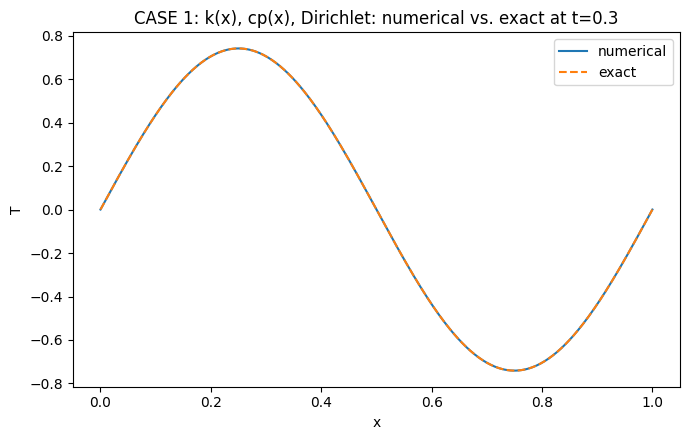

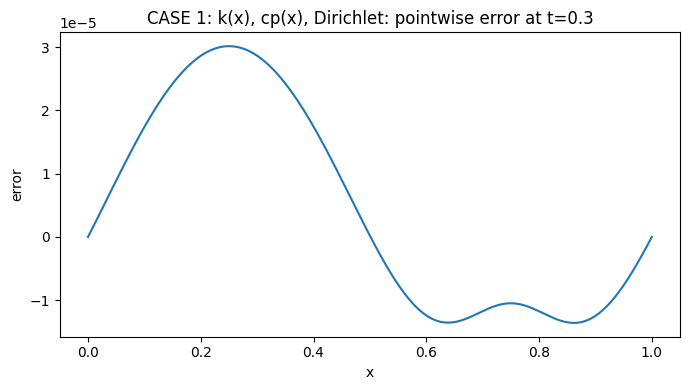

[CASE 2: Robin BCs, time-dependent] t=0.6000, N=321, dt=0.001  ->  L2=6.212e-01, Linf=1.131e+00


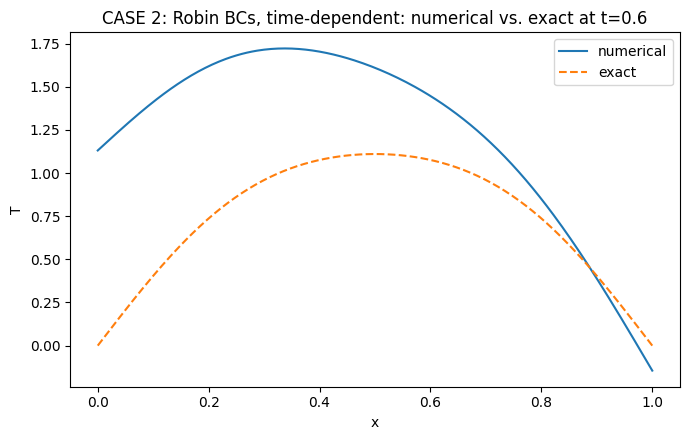

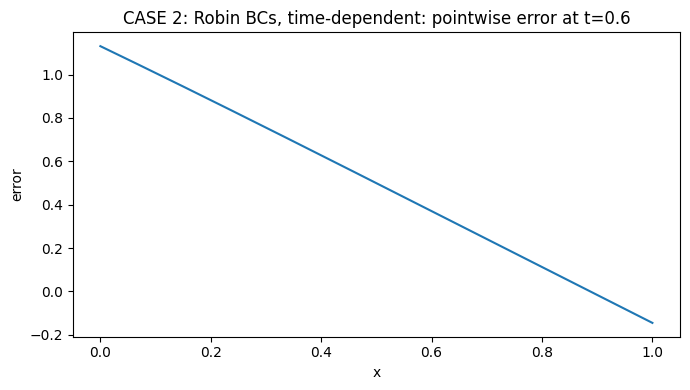

[CASE 3: nonlinear k(T), Dirichlet] t=0.5000, N=321, dt=0.00075  ->  L2=4.237e-06, Linf=6.229e-06


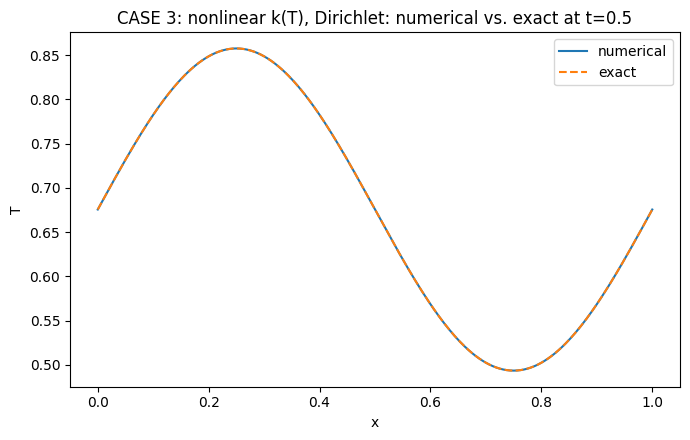

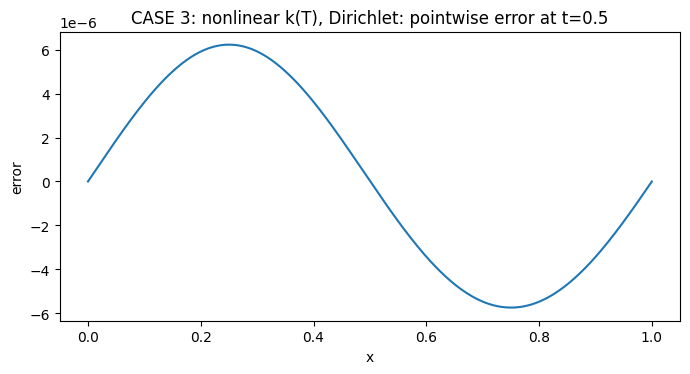

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# --------------------------- small helper: run & compare ---------------------------
def run_and_compare(name, grid, material, source, bc, u_exact,
                    t0=0.0, tf=0.4, dt=1e-3, theta=0.5,
                    plot=True):
    solver = Heat1DSolver(grid, material, source, bc, theta=theta, max_iter=30, tol=1e-12)
    T0 = u_exact(grid.x, t0)
    T_end, t_end = solver.run(T0, t0, tf, dt)

    Ue = u_exact(grid.x, t_end)
    err = T_end - Ue
    L2   = np.sqrt(np.sum(err**2) * grid.dx)
    Linf = np.max(np.abs(err))
    print(f"[{name}] t={t_end:.4f}, N={grid.N}, dt={dt:g}  ->  L2={L2:.3e}, Linf={Linf:.3e}")

    if plot:
        plt.figure(figsize=(7,4.5))
        plt.plot(grid.x, T_end, label="numerical")
        plt.plot(grid.x, Ue, '--', label="exact")
        plt.xlabel("x"); plt.ylabel("T")
        plt.title(f"{name}: numerical vs. exact at t={t_end:g}")
        plt.legend(); plt.tight_layout()

        plt.figure(figsize=(7,4.0))
        plt.plot(grid.x, err)
        plt.xlabel("x"); plt.ylabel("error")
        plt.title(f"{name}: pointwise error at t={t_end:g}")
        plt.tight_layout()
        plt.show()

# ===================================================================================
# CASE 1 — Variable k(x) AND variable capacity c_p(x); Dirichlet BCs
# PDE:  rho(x) cp(x) T_t = d/dx[ k(x) T_x ] + q'''(x,t)
# Exact: u = e^{-t} sin(2πx)
# -----------------------------------------------------------------------------------
L = 1.0
grid1 = Grid1D(L=L, N=401)

def u1(x, t):
    return np.exp(-t) * np.sin(2*np.pi*x)

def u1_t(x, t):
    return -np.exp(-t) * np.sin(2*np.pi*x)

def u1_x(x, t):
    return np.exp(-t) * (2*np.pi) * np.cos(2*np.pi*x)

def u1_xx(x, t):
    return -np.exp(-t) * (2*np.pi)**2 * np.sin(2*np.pi*x)

# Variable properties
def k1(x):     # smooth, positive conductivity
    return 1.0 + 0.5*np.sin(2*np.pi*x)

def k1_x(x):   # derivative wrt x
    return (0.5*2*np.pi)*np.cos(2*np.pi*x)  # = π cos(2πx)

def rho1(x):
    return 1.0 + 0.0*x

def cp1(x):
    return 1.0 + 0.3*np.cos(np.pi*x)  # variable heat capacity, > 0.7

# Manufactured source: q''' = rho*cp*u_t - d/dx( k u_x ) = rho cp u_t - [k_x u_x + k u_xx]
def qdot1(x, t):
    return rho1(x)*cp1(x)*u1_t(x,t) - (k1_x(x)*u1_x(x,t) + k1(x)*u1_xx(x,t))

material1 = MaterialFuncs(
    rho=lambda x, t, T: rho1(x),
    cp =lambda x, t, T: cp1(x),
    k  =lambda x, t, T: k1(x)
)
source1 = SourceFunc(qdot=lambda x, t: qdot1(x, t))
bc1 = BCFunc(
    left = lambda t: ("Dirichlet", 0.0),     # u(0,t)=0
    right= lambda t: ("Dirichlet", 0.0)      # u(1,t)=0
)

# Run Case 1
run_and_compare("CASE 1: k(x), cp(x), Dirichlet",
                grid1, material1, source1, bc1, u1,
                tf=0.3, dt=1.0e-3, theta=0.5, plot=True)

# ===================================================================================
# CASE 2 — Time-dependent ROBIN BCs (convection), constant properties
# PDE:  T_t = k T_xx + q'''
# Exact: u(x,t) = A(t) sin(πx) + B(t) sin(3πx), k=1
# Robin: -k T_x = h (T - T_inf). We choose T_inf so the exact solution satisfies this.
# -----------------------------------------------------------------------------------
grid2 = Grid1D(L=1.0, N=321)
k2 = 1.0
rho2 = 1.0
cp2 = 1.0

def A(t):  return 1.0 + 0.2*np.cos(t)
def B(t):  return 0.1*np.exp(-t)
def A_t(t): return -0.2*np.sin(t)
def B_t(t): return -0.1*np.exp(-t)

def u2(x, t):
    return A(t)*np.sin(np.pi*x) + B(t)*np.sin(3*np.pi*x)

def u2_t(x, t):
    return A_t(t)*np.sin(np.pi*x) + B_t(t)*np.sin(3*np.pi*x)

def u2_x(x, t):
    return A(t)*np.pi*np.cos(np.pi*x) + B(t)*3*np.pi*np.cos(3*np.pi*x)

def u2_xx(x, t):
    return -A(t)*(np.pi**2)*np.sin(np.pi*x) - B(t)*(3*np.pi)**2*np.sin(3*np.pi*x)

# Source: q''' = rho cp u_t - d/dx(k u_x) = u_t - k u_xx    (k constant)
def qdot2(x, t):
    return u2_t(x,t) - k2*u2_xx(x,t)

hL, hR = 5.0, 10.0  # convection coefficients

# T_inf(t) chosen to *enforce* the Robin bc with the exact u:
#   -k u_x = h (u - T_inf)  =>  T_inf = u + (k/h) u_x, evaluated at the boundary
def bc2_left(t):
    T = u2(0.0, t)
    dTdx = u2_x(0.0, t)            # cos terms at x=0 => cos(0)=1
    Tinf = T + (k2/hL)*dTdx
    return ("Robin", (hL, float(Tinf)))

def bc2_right(t):
    T = u2(1.0, t)
    dTdx = u2_x(1.0, t)            # cos(nπ) = (-1)^n
    Tinf = T + (k2/hR)*dTdx
    return ("Robin", (hR, float(Tinf)))

material2 = MaterialFuncs(
    rho=lambda x, t, T: np.full_like(x, rho2, dtype=float),
    cp =lambda x, t, T: np.full_like(x, cp2, dtype=float),
    k  =lambda x, t, T: np.full_like(x, k2,  dtype=float),
)
source2 = SourceFunc(qdot=lambda x, t: qdot2(x, t))
bc2 = BCFunc(left=bc2_left, right=bc2_right)

# Run Case 2
run_and_compare("CASE 2: Robin BCs, time-dependent",
                grid2, material2, source2, bc2, u2,
                tf=0.6, dt=1.0e-3, theta=0.5, plot=True)

# ===================================================================================
# CASE 3 — NONLINEAR conductivity k(T) = 1 + β T; time-dependent Dirichlet BCs
# PDE:  T_t = d/dx[(1+βT) T_x] + q'''
# Exact: u(x,t) = 0.5 + 0.2 cos t + 0.3 e^{-t} sin(2πx)
# -----------------------------------------------------------------------------------
grid3 = Grid1D(L=1.0, N=321)
beta = 0.25
rho3 = 1.0
cp3  = 1.0

def u3(x, t):
    return 0.5 + 0.2*np.cos(t) + 0.3*np.exp(-t)*np.sin(2*np.pi*x)

def u3_t(x, t):
    return -0.2*np.sin(t) - 0.3*np.exp(-t)*np.sin(2*np.pi*x)

def u3_x(x, t):
    return 0.3*np.exp(-t)*(2*np.pi)*np.cos(2*np.pi*x)

def u3_xx(x, t):
    return -0.3*np.exp(-t)*(2*np.pi)**2*np.sin(2*np.pi*x)

# Nonlinear flux divergence: d/dx[(1+βu) u_x] = β u_x*u_x + (1+βu) u_xx
# So q''' = rho cp u_t - d/dx[(1+βu) u_x] = u_t - [β (u_x)^2 + (1+βu) u_xx]
def qdot3(x, t):
    ux  = u3_x(x,t)
    uxx = u3_xx(x,t)
    return u3_t(x,t) - (beta*ux*ux + (1.0 + beta*u3(x,t))*uxx)

material3 = MaterialFuncs(
    rho=lambda x, t, T: np.full_like(x, rho3, dtype=float),
    cp =lambda x, t, T: np.full_like(x, cp3,  dtype=float),
    k  =lambda x, t, T: 1.0 + beta*T          # NOTE: depends on T (nonlinear)
)

source3 = SourceFunc(qdot=lambda x, t: qdot3(x, t))

# Time-dependent Dirichlet BCs match the exact solution at the boundaries
bc3 = BCFunc(
    left = lambda t: ("Dirichlet", float(u3(0.0, t))),
    right= lambda t: ("Dirichlet", float(u3(1.0, t))),
)

# Run Case 3 (use a slightly smaller dt to help Picard converge tightly)
run_and_compare("CASE 3: nonlinear k(T), Dirichlet",
                grid3, material3, source3, bc3, u3,
                tf=0.5, dt=7.5e-4, theta=0.5, plot=True)


# Heat loss through composite wall

A laboratory built in the Antarctic has a composite wall made up of plasterboard (10 mm), fibreglass insulation (100 mm), and plywood (20 mm). 
The inside room temperature is maintained at $T_i = 293 \,\text{K}$ throughout. 
The plywood is exposed to an outside temperature $T_o$ that varies with time $t$ (in hours) as

$$
T_o =
\begin{cases}
273 + 5 \sin\left( \dfrac{\pi}{12} t \right), & 0 \leq t \leq 12 \, \text{h}, \\[1em]
273 + 30 \sin\left( \dfrac{\pi}{12} t \right), & 12 \leq t \leq 24 \, \text{h}.
\end{cases}
$$


* Compute the heat loss to the outside over a typical 24-h period (i.e., under periodic steady state) in $J/m^2$.
* Plot the variation of interface temperatures between the plasterboard and the fibreglass, and between the fibreglass and the plywood as a function of time. 
Assume: $h_i = 15 \,\text{W/m}^2\text{-K}$ and $h_o = 60 \,\text{W/m}^2\text{-K}$. 
Material properties are given in Table 2.9.

=== Key results (last 24 hours in periodic steady state) ===
Average heat loss to outside (via outside film): 3.597 W/m^2
Average heat leaving the room (via inside film): 3.610 W/m^2
Daily energy lost per unit area (outside): 310.75 kJ/m^2 per day
Sanity check (overall U * mean ΔT):
  Overall R = 2.809 m^2·K/W -> U = 0.356 W/m^2·K, ΔT_mean = 20.0 K
  Predicted average by resistance method: 7.120 W/m^2


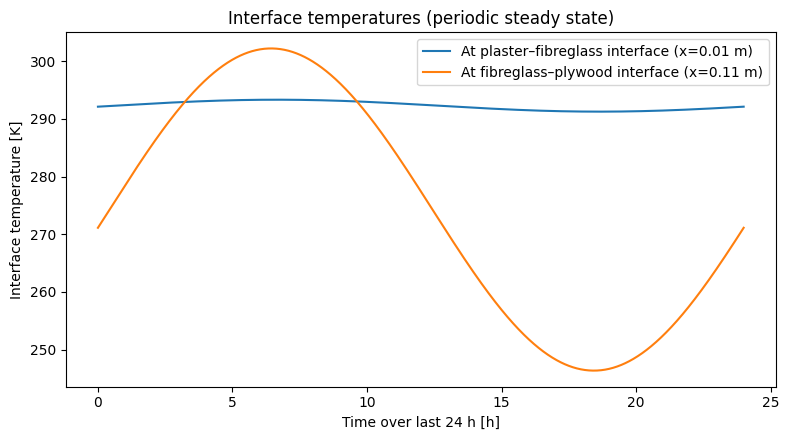

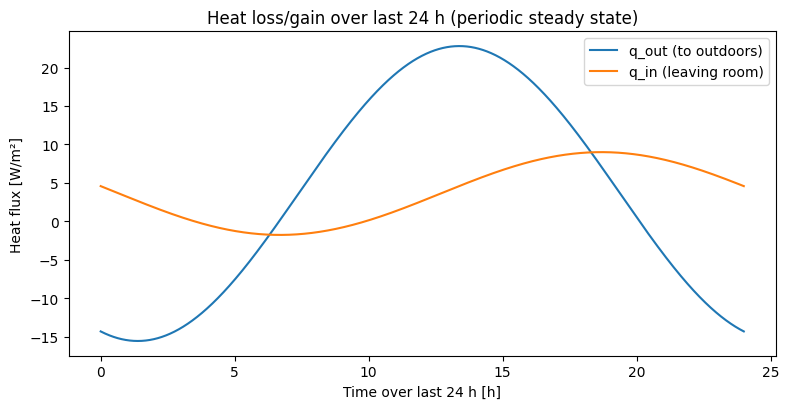

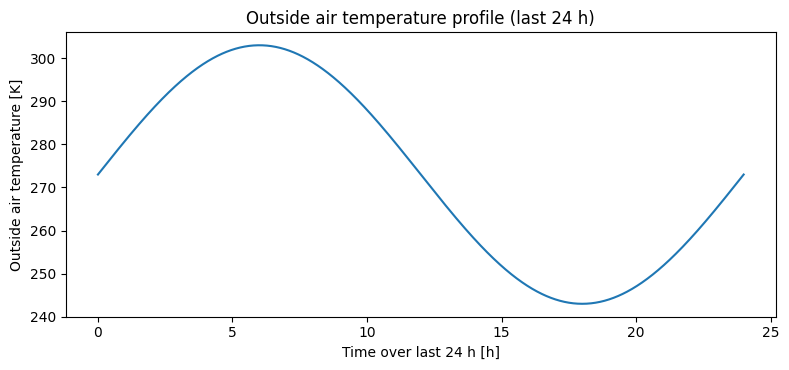

In [3]:
# -----------------------
# Problem set-up

# Geometry (m)
L_plaster = 0.010   # 10 mm
L_fibreg  = 0.100   # 100 mm
L_plywood = 0.020   # 20 mm
L_total   = L_plaster + L_fibreg + L_plywood

# Grid
N = 350  # fine grid for smooth interfaces
grid = Grid1D(L=L_total, N=N)

# Material properties (assumed typical values)
# (If your textbook problem 8 lists different values, swap them here.)
k_plaster = 0.17   # W/m-K (gypsum board)
rho_plaster = 950.0  # kg/m3
cp_plaster = 840.0   # J/kg-K

k_fibreg = 0.040   # W/m-K
rho_fibreg = 12.0  # kg/m3
cp_fibreg = 800.0  # J/kg-K

k_plywood = 0.12   # W/m-K
rho_plywood = 540.0  # kg/m3
cp_plywood = 1600.0  # J/kg-K

# Piecewise-constant property helpers
x_break1 = L_plaster
x_break2 = L_plaster + L_fibreg

def pick_region(x):
    """Return 0 for plaster, 1 for fibreglass, 2 for plywood, vectorized."""
    reg = np.zeros_like(x, dtype=int)
    reg[x >= x_break1] = 1
    reg[x >= x_break2] = 2
    return reg

def rho_fun(x, t, T):
    reg = pick_region(x)
    out = np.empty_like(x)
    out[reg==0] = rho_plaster
    out[reg==1] = rho_fibreg
    out[reg==2] = rho_plywood
    return out

def cp_fun(x, t, T):
    reg = pick_region(x)
    out = np.empty_like(x)
    out[reg==0] = cp_plaster
    out[reg==1] = cp_fibreg
    out[reg==2] = cp_plywood
    return out

def k_fun(x, t, T):
    reg = pick_region(x)
    out = np.empty_like(x)
    out[reg==0] = k_plaster
    out[reg==1] = k_fibreg
    out[reg==2] = k_plywood
    return out

material = MaterialFuncs(rho=rho_fun, cp=cp_fun, k=k_fun)

# No internal heat generation
source = SourceFunc(qdot=lambda x, t: np.zeros_like(x))

# Convection data
hi = 15.0  # W/m2-K (inside)
ho = 60.0  # W/m2-K (outside)
Ti = 293.0 # K (room air, constant)

# Outside air temperature To(t), t in seconds -> convert to hours for the given expression
def To_time(t):
    hours = t / 3600.0
    if hours <= 12.0:
        return 273.0 + 5.0 * np.sin(np.pi * hours / 12.0)
    else:
        return 273.0 + 30.0 * np.sin(np.pi * hours / 12.0)

# Boundary condition functions (Robin: convection)
def left_bc(t):
    # left is the room side (plasterboard exposed to room air)
    return ("Robin", (hi, Ti))

def right_bc(t):
    # right is outdoors (plywood exposed to outside air)
    return ("Robin", (ho, To_time(t)))

bc = BCFunc(left=left_bc, right=right_bc)

# Solver
solver = Heat1DSolver(grid=grid, material=material, source=source, bc=bc, theta=0.5)

# Initial condition (start at indoor temperature everywhere)
T_init = np.full(grid.N, Ti)

# Time integration: run for several days to reach periodic steady state
day = 24 * 3600.0
t_total = 8 * day       # run 8 days
dt = 60.0               # 1-minute steps

times = []
T_record = []

# We'll also track interface temperatures and heat fluxes
x = grid.x
i_int1 = np.argmin(np.abs(x - x_break1))  # plaster/fibreglass interface
i_int2 = np.argmin(np.abs(x - x_break2))  # fibreglass/plywood interface
T_int1 = []
T_int2 = []
q_out = []  # outward heat flux on the external surface
q_in = []   # heat leaving the room (positive into wall)

def callback(t, T):
    times.append(t)
    T_record.append(T.copy())
    T_int1.append(T[i_int1])
    T_int2.append(T[i_int2])
    # Convective heat fluxes (+) defined as "from solid to fluid" (out of the solid)
    To = To_time(t)
    q_out.append(ho * (T[-1] - To))  # W/m2, outward to ambient
    q_in.append(hi * (Ti - T[0]))    # W/m2, leaving room into wall

# Run
_ = solver.run(T0=T_init, t0=0.0, tf=t_total, dt=dt, callback=callback)

times = np.array(times)
T_int1 = np.array(T_int1)
T_int2 = np.array(T_int2)
q_out = np.array(q_out)
q_in = np.array(q_in)

# Consider only the last 24 hours (periodic steady state)
mask_last_day = times >= (t_total - day)
t_last = times[mask_last_day] - times[mask_last_day][0]
Tint1_last = T_int1[mask_last_day]
Tint2_last = T_int2[mask_last_day]
qout_last  = q_out[mask_last_day]
qin_last   = q_in[mask_last_day]

# Time-averaged heat loss to outside (as W/m^2). We'll report both sides for a check.
qout_mean = qout_last.mean()
qin_mean  = qin_last.mean()
E_day_per_area_out = qout_last.mean() * day  # J/m2 over 24 h

# Also compute the simple steady (resistance) prediction for sanity check:
R_total = (1/hi) + (L_plaster/k_plaster) + (L_fibreg/k_fibreg) + (L_plywood/k_plywood) + (1/ho)
U = 1.0 / R_total
DeltaT_mean = Ti - (273.0)  # mean outside air is 273 K because <sin> = 0
q_mean_resistance = U * DeltaT_mean

# Print key numbers
print("=== Key results (last 24 hours in periodic steady state) ===")
print(f"Average heat loss to outside (via outside film): {qout_mean:.3f} W/m^2")
print(f"Average heat leaving the room (via inside film): {qin_mean:.3f} W/m^2")
print(f"Daily energy lost per unit area (outside): {E_day_per_area_out/1000:.2f} kJ/m^2 per day")
print("Sanity check (overall U * mean ΔT):")
print(f"  Overall R = {R_total:.3f} m^2·K/W -> U = {U:.3f} W/m^2·K, ΔT_mean = {DeltaT_mean:.1f} K")
print(f"  Predicted average by resistance method: {q_mean_resistance:.3f} W/m^2")

# ---- Plots ----

# 1) Interface temperatures over the last day
plt.figure(figsize=(8,4.5))
plt.plot(t_last/3600.0, Tint1_last, label="At plaster–fibreglass interface (x=0.01 m)")
plt.plot(t_last/3600.0, Tint2_last, label="At fibreglass–plywood interface (x=0.11 m)")
plt.xlabel("Time over last 24 h [h]")
plt.ylabel("Interface temperature [K]")
plt.title("Interface temperatures (periodic steady state)")
plt.legend()
plt.tight_layout()
plt.show()

# 2) Heat fluxes through the wall (last day)
plt.figure(figsize=(8,4.2))
plt.plot(t_last/3600.0, qout_last, label="q_out (to outdoors)")
plt.plot(t_last/3600.0, qin_last, label="q_in (leaving room)")
plt.xlabel("Time over last 24 h [h]")
plt.ylabel("Heat flux [W/m²]")
plt.title("Heat loss/gain over last 24 h (periodic steady state)")
plt.legend()
plt.tight_layout()
plt.show()

# 3) Outside air temperature over the last day for reference
To_last = np.array([To_time(t) for t in times[mask_last_day]])
plt.figure(figsize=(8,3.8))
plt.plot(t_last/3600.0, To_last)
plt.xlabel("Time over last 24 h [h]")
plt.ylabel("Outside air temperature [K]")
plt.title("Outside air temperature profile (last 24 h)")
plt.tight_layout()
plt.show()


# Gluing two materials

Two plastic sheets, each 5 mm thick, are to be bonded together with a thin layer of adhesive that fuses at $149^\circ C$. For this purpose, they are pressed between two surfaces at $250^\circ C$. Determine the time for which the two sheets should be pressed together, if the initial temperature of the sheets (and the adhesive) is $30^\circ C$. 
For plastic sheets, $k = 0.25 \,\text{W/m-K}$, $C = 2000 \,\text{J/kg-K}$, and $\rho = 1300 \,\text{kg/m}^3$.

In [4]:
def solve_prob1_plastic_fusion(
    N: int = 7,
    theta: float = 0.5,
    dt: float | None = None,
    t_max: float = 3600.0,
    T_std: float = 30.0,
    T_bnd: float = 250.0,
    T_melt: float = 140.0,
):
    """
    Prob 1: Two plastic sheets, each 5 mm, pressed between 250 C plates.
    Find time until the interface (center) reaches 140 C.

    Uses the Heat1DSolver you provided (Crank–Nicolson + Picard).
    Returns (t_fuse, history, final_T, grid, material_info).
    """
    # Geometry
    b = 0.005            # each sheet 5 mm
    L = 2 * b            # total thickness
    grid = Grid1D(L=L, N=N)

    # Material (constants, but functions of (x,t,T) as required)
    k_val   = 0.26       # W/m-K
    rho_val = 1300.0     # kg/m^3
    cp_val  = 2000.0     # J/kg-K
    alpha   = k_val / (rho_val * cp_val)  # ~1e-7 m^2/s

    def rho_fn(x, t, T): return np.full_like(x, rho_val, dtype=float)
    def cp_fn(x, t, T):  return np.full_like(x, cp_val,  dtype=float)
    def k_fn(x, t, T):   return np.full_like(x, k_val,   dtype=float)

    material = MaterialFuncs(rho=rho_fn, cp=cp_fn, k=k_fn)

    # Source term (none)
    def qdot_fn(x, t): return np.zeros_like(x)
    source = SourceFunc(qdot=qdot_fn)

    # Boundary conditions: both ends held at T_bnd (Dirichlet)
    def bc_left(t):  return "Dirichlet", T_bnd
    def bc_right(t): return "Dirichlet", T_bnd
    bc = BCFunc(left=bc_left, right=bc_right)

    # Initial condition
    T = np.full(grid.N, T_std, dtype=float)

    # Choose a time step: CN has no stability limit, but use diffusive scaling for accuracy
    dx = grid.dx
    if dt is None:
        dt = 0.2 * dx * dx / alpha   # conservative for accuracy

    # Build solver
    solver = Heat1DSolver(grid, material, source, bc, theta=theta, max_iter=30, tol=1e-10)

    # Interface index (center)
    i_center = grid.N // 2

    # Time loop until fusion or t_max
    t = 0.0
    history = {"time": [], "T_center": [], "T_left": [], "T_right": []}
    while t < t_max - 1e-15:
        # advance one step
        T, t = solver.step(T, dt, t)

        # record
        history["time"].append(t)
        history["T_center"].append(T[i_center])
        history["T_left"].append(T[0])
        history["T_right"].append(T[-1])

        # fusion check
        if T[i_center] >= T_melt:
            return t, history, T, grid, {"k": k_val, "rho": rho_val, "cp": cp_val, "alpha": alpha, "dt": dt}

    # If not fused within t_max
    return None, history, T, grid, {"k": k_val, "rho": rho_val, "cp": cp_val, "alpha": alpha, "dt": dt}

t_fuse, hist, T_final, grid, info = solve_prob1_plastic_fusion()
print(f"dx = {grid.dx:.3e} m, dt = {info['dt']:.3e} s, alpha = {info['alpha']:.3e} m^2/s")
if t_fuse is None:
    print("Did not reach 140 C within t_max.")
else:
    print(f"Interface reached 140 C at t = {t_fuse:.2f} s")



dx = 1.667e-03 m, dt = 5.556e+00 s, alpha = 1.000e-07 m^2/s
Interface reached 140 C at t = 100.00 s


Finished at t = 1.000000 with N=201, dt=0.0025
L2 error  = 5.177177e-06
Linf error= 7.321634e-06


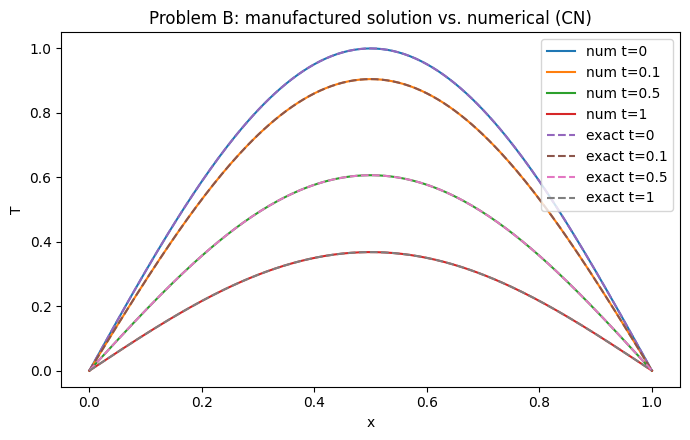

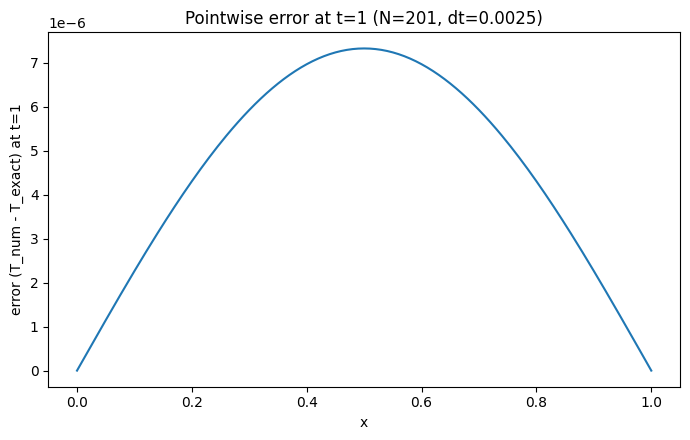

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# ---- paste your classes & helpers above this line (Grid1D, MaterialFuncs, SourceFunc, BCFunc, Heat1DSolver, etc.) ----
# Assumes the definitions you provided are already in scope.

# --- Problem B setup ---
L = 1.0
N = 201                 # spatial points (refine to see smaller error)
grid = Grid1D(L=L, N=N)

# Physical properties (constants)
rho_c = 1.0
cp_c  = 1.0
alpha = 0.1             # choose alpha = k/(rho*cp)
k_c   = alpha * rho_c * cp_c  # so that alpha is exactly what we chose

# MaterialFuncs need array-valued callables of (x, t, T) -> array
material = MaterialFuncs(
    rho=lambda x, t, T: np.full_like(x, rho_c, dtype=float),
    cp =lambda x, t, T: np.full_like(x, cp_c, dtype=float),
    k  =lambda x, t, T: np.full_like(x, k_c, dtype=float),
)

# Exact solution and source term
def u_exact(x, t):
    return np.exp(-t) * np.sin(np.pi * x)

# Manufactured source: qdot = (rho*cp * u_t - k * u_xx)
# u_t = -e^{-t} sin(pi x), u_xx = -pi^2 e^{-t} sin(pi x)
# => qdot = (-rho*cp + k*pi**2) e^{-t} sin(pi x) = rho*cp*(-1 + alpha*pi**2) e^{-t} sin(pi x)
def qdot_fun(x, t):
    return ( -rho_c*cp_c + k_c*(np.pi**2) ) * np.exp(-t) * np.sin(np.pi * x)

source = SourceFunc(qdot=lambda x, t: qdot_fun(x, t))

# Dirichlet BCs: u(0,t)=0, u(1,t)=0
bc = BCFunc(
    left = lambda t: ("Dirichlet", 0.0),
    right= lambda t: ("Dirichlet", 0.0),
)

# Time integrator
theta = 0.5          # Crank–Nicolson
solver = Heat1DSolver(grid, material, source, bc, theta=theta, max_iter=20, tol=1e-12)

# Initial condition matches exact at t=0
T0 = u_exact(grid.x, 0.0)

# Time settings
t0, tf = 0.0, 1.0
dt = 2.5e-3          # refine (e.g., 1.25e-3) for smaller time error

# Storage for a few snapshots
snap_t = [0.0, 0.1, 0.5, 1.0]
snap_T_num = {snap_t[0]: T0.copy()}
snap_T_exa = {snap_t[0]: u_exact(grid.x, snap_t[0])}

def callback_store(t, T):
    # If t crosses a snapshot time (to within half a time step), store it
    for ts in snap_t:
        if (ts not in snap_T_num) and (abs(t - ts) <= 0.5*dt + 1e-12):
            snap_T_num[ts] = T.copy()
            snap_T_exa[ts] = u_exact(grid.x, ts)

# Run
T_end, t_end = solver.run(T0, t0, tf, dt, callback=callback_store)

# Final-time error
Ue = u_exact(grid.x, t_end)
err = T_end - Ue
dx = grid.dx
L2  = np.sqrt(np.sum(err**2) * dx)
Linf = np.max(np.abs(err))

print(f"Finished at t = {t_end:.6f} with N={N}, dt={dt}")
print(f"L2 error  = {L2:.6e}")
print(f"Linf error= {Linf:.6e}")

# --- Plots ---
plt.figure(figsize=(7,4.5))
for ts in snap_t:
    if ts in snap_T_num:
        plt.plot(grid.x, snap_T_num[ts], label=f"num t={ts:g}")
for ts in snap_t:
    plt.plot(grid.x, snap_T_exa[ts], '--', label=f"exact t={ts:g}")
plt.xlabel("x")
plt.ylabel("T")
plt.title("Problem B: manufactured solution vs. numerical (CN)")
plt.legend(loc="best")
plt.tight_layout()

plt.figure(figsize=(7,4.5))
plt.plot(grid.x, T_end - Ue)
plt.xlabel("x")
plt.ylabel("error (T_num - T_exact) at t=1")
plt.title(f"Pointwise error at t={t_end:g} (N={N}, dt={dt})")
plt.tight_layout()

plt.show()


[CASE 1: k(x), cp(x), Dirichlet] t=0.3000, N=401, dt=0.001  ->  L2=1.683e-05, Linf=3.015e-05


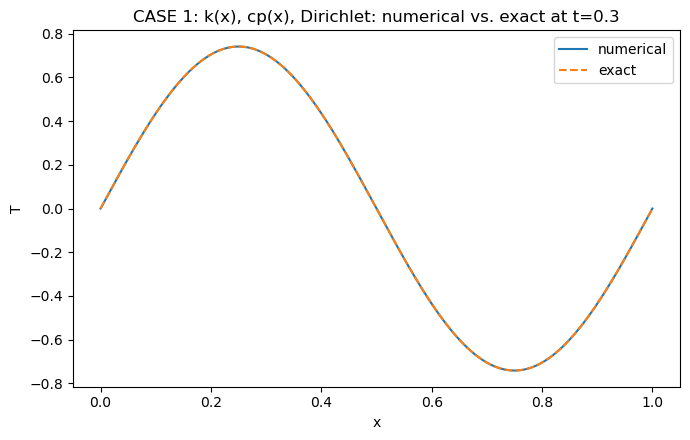

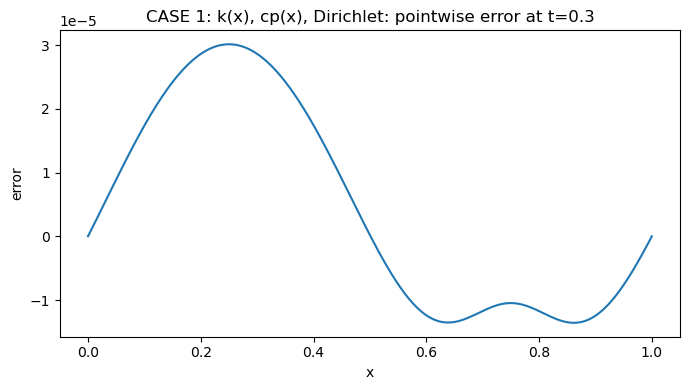

[CASE 2: Robin BCs, time-dependent] t=0.6000, N=321, dt=0.001  ->  L2=6.212e-01, Linf=1.131e+00


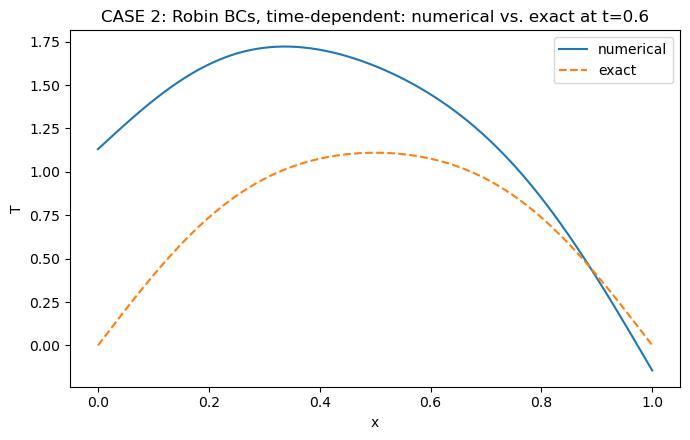

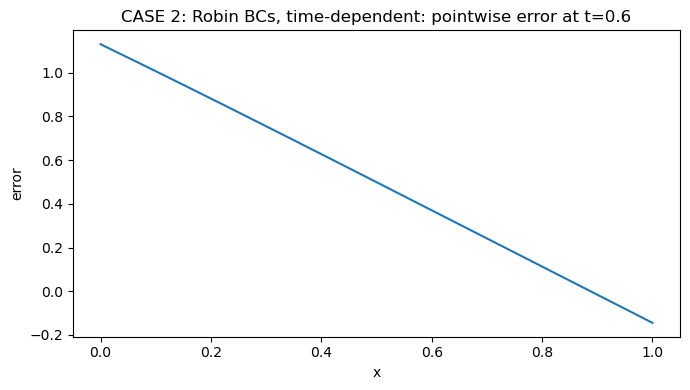

[CASE 3: nonlinear k(T), Dirichlet] t=0.5000, N=321, dt=0.00075  ->  L2=4.237e-06, Linf=6.229e-06


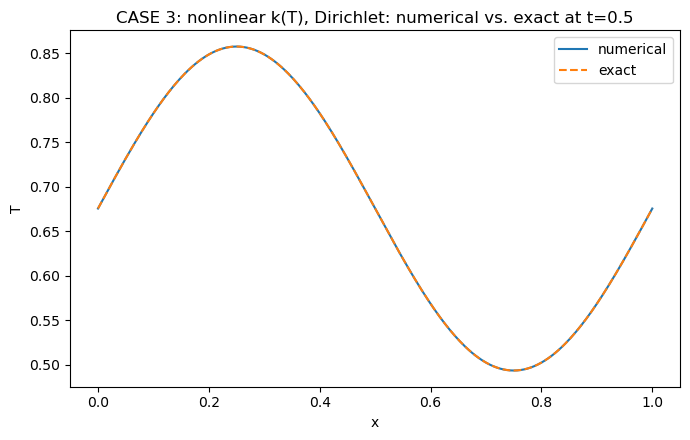

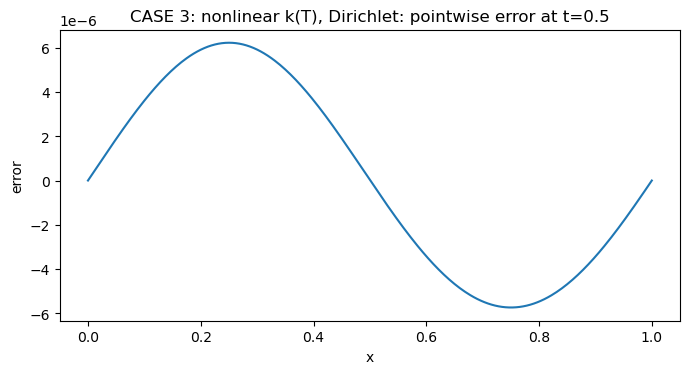